<a href="https://colab.research.google.com/github/flahbocchino/pbl_fase6_FlaviaBocchino---PedroZani/blob/main/PBL_Fase6_IrAlem_TransferLearning_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧪 PBL Fase 6 — “Ir Além” (Opção 2)
## Transfer Learning + Fine Tuning com MobileNetV2

**Curso:** Inteligência Artificial — FIAP  
**Alunos:**  
- Flavia Bocchino (RM564213)  
- Pedro Zani (RM564956)  

---

### 🎯 Objetivo
Implementar um modelo de **classificação de imagens** usando **Transfer Learning** e **Fine Tuning**, com base na **MobileNetV2** pré-treinada na ImageNet.  
O modelo distinguirá entre duas classes já utilizadas no YOLOv5:

- **Classe 0:** desenho  
- **Classe 1:** sofá  

A finalidade é comparar desempenho, tempo e aplicabilidade dessa técnica com o modelo YOLOv5 treinado anteriormente.

---


In [2]:
# 0) Imports
import os, glob, shutil, time, itertools
from pathlib import Path
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# para resultados
os.makedirs("/content/clf_results", exist_ok=True)


In [3]:
# 1) Montar estrutura de classificação (folders por classe)
SRC = "/content/datasets/images"                     # de quando montamos o YOLO
DST = "/content/classif_data"                        # novo dataset de classificação
classes = {"A_": "desenho", "B_": "sofa"}

for split in ["train","val","test"]:
    for cname in classes.values():
        os.makedirs(f"{DST}/{split}/{cname}", exist_ok=True)

def route(img_path):
    name = Path(img_path).name
    if name.startswith("A_"):
        return "desenho"
    elif name.startswith("B_"):
        return "sofa"
    else:
        return None

total_moved = 0
for split in ["train","val","test"]:
    imgs = sorted(glob.glob(f"{SRC}/{split}/*.*"))
    for p in imgs:
        cls = route(p)
        if cls:
            shutil.copy2(p, f"{DST}/{split}/{cls}/{Path(p).name}")
            total_moved += 1

print("Imagens copiadas para classificação:", total_moved)
!find /content/classif_data -maxdepth 3 -type d -print


Imagens copiadas para classificação: 0
/content/classif_data
/content/classif_data/test
/content/classif_data/test/sofa
/content/classif_data/test/desenho
/content/classif_data/train
/content/classif_data/train/sofa
/content/classif_data/train/desenho
/content/classif_data/val
/content/classif_data/val/sofa
/content/classif_data/val/desenho


In [5]:
!git clone https://github.com/flahbocchino/pbl_fase6_FlaviaBocchino---PedroZani.git /content/repo
SRC = "/content/repo/imagens"  # ajuste se suas imagens estiverem em outro lugar

# só para conferir que tem A_*.jpg e B_*.jpg
import glob, os
print("A:", len(glob.glob(f"{SRC}/A_*.jpg")) + len(glob.glob(f"{SRC}/A_*.png")))
print("B:", len(glob.glob(f"{SRC}/B_*.jpg")) + len(glob.glob(f"{SRC}/B_*.png")))


Cloning into '/content/repo'...
remote: Enumerating objects: 265, done.
remote: Counting objects: 100% (265/265), done.
remote: Compressing objects: 100% (163/163), done.
remote: Total 265 (delta 14), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (265/265), 29.33 MiB | 19.16 MiB/s, done.
Resolving deltas: 100% (14/14), done.
A: 49
B: 50


In [6]:
import os, shutil, glob, random

DST = "/content/classif_data"  # destino do dataset de classificação
random.seed(42)

# zera e recria a estrutura
shutil.rmtree(DST, ignore_errors=True)
for split in ["train", "val", "test"]:
    os.makedirs(f"{DST}/{split}/desenho", exist_ok=True)
    os.makedirs(f"{DST}/{split}/sofa", exist_ok=True)

# pega as imagens
A_imgs = sorted(glob.glob(f"{SRC}/A_*.jpg")) + sorted(glob.glob(f"{SRC}/A_*.png"))
B_imgs = sorted(glob.glob(f"{SRC}/B_*.jpg")) + sorted(glob.glob(f"{SRC}/B_*.png"))

def split_and_copy(imgs, cls):
    n = len(imgs)
    random.shuffle(imgs)
    n_tr = int(0.8 * n)
    n_val = int(0.1 * n)
    splits = {
        "train": imgs[:n_tr],
        "val": imgs[n_tr:n_tr + n_val],
        "test": imgs[n_tr + n_val:]
    }
    for split, lst in splits.items():
        for src in lst:
            shutil.copy(src, f"{DST}/{split}/{cls}/{os.path.basename(src)}")

split_and_copy(A_imgs, "desenho")
split_and_copy(B_imgs, "sofa")

# conferência rápida
for s in ["train", "val", "test"]:
    nA = len(os.listdir(f"{DST}/{s}/desenho"))
    nB = len(os.listdir(f"{DST}/{s}/sofa"))
    print(f"{s}: desenho={nA}  sofa={nB}")


train: desenho=39  sofa=40
val: desenho=4  sofa=5
test: desenho=6  sofa=5


In [9]:
# criar pasta base e clonar o repositório novamente
%cd /content
!rm -rf /content/datasets
!mkdir -p /content/datasets
%cd /content/datasets

!git clone https://github.com/flahbocchino/pbl_fase6_FlaviaBocchino---PedroZani.git

# confirmar que a pasta "imagens" existe
!ls /content/datasets/pbl_fase6_FlaviaBocchino---PedroZani/imagens


/content
/content/datasets
Cloning into 'pbl_fase6_FlaviaBocchino---PedroZani'...
remote: Enumerating objects: 265, done.
remote: Counting objects: 100% (265/265), done.
remote: Compressing objects: 100% (163/163), done.
remote: Total 265 (delta 14), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (265/265), 29.33 MiB | 19.54 MiB/s, done.
Resolving deltas: 100% (14/14), done.
A_01.jpg  A_15.jpg  A_28.jpg  A_41.jpg	B_04.jpg  B_17.jpg  B_30.jpg  B_43.jpg
A_02.jpg  A_16.jpg  A_29.jpg  A_42.jpg	B_05.jpg  B_18.jpg  B_31.jpg  B_44.jpg
A_03.jpg  A_17.jpg  A_30.jpg  A_43.jpg	B_06.jpg  B_19.jpg  B_32.jpg  B_45.jpg
A_05.jpg  A_18.jpg  A_31.jpg  A_44.jpg	B_07.jpg  B_20.jpg  B_33.jpg  B_46.jpg
A_06.jpg  A_19.jpg  A_32.jpg  A_45.jpg	B_08.jpg  B_21.jpg  B_34.jpg  B_47.jpg
A_07.jpg  A_20.jpg  A_33.jpg  A_46.jpg	B_09.jpg  B_22.jpg  B_35.jpg  B_48.jpg
A_08.jpg  A_21.jpg  A_34.jpg  A_47.jpg	B_10.jpg  B_23.jpg  B_36.jpg  B_49.jpg
A_09.jpg  A_22.jpg  A_35.jpg  A_48.jpg	B_11.jpg  B_24.jp

In [10]:
DST = "/content/datasets/pbl_fase6_FlaviaBocchino---PedroZani/imagens"


In [12]:
# === PREPARAR ESTRUTURA DE CLASSES ===
import os, glob, shutil

SRC = "/content/datasets/pbl_fase6_FlaviaBocchino---PedroZani/imagens"  # onde estão A_*.jpg e B_*.jpg
ROOT = "/content/datasets/tl_data"  # nova raiz com subpastas de classes

# recomeçar limpo
shutil.rmtree(ROOT, ignore_errors=True)
os.makedirs(ROOT, exist_ok=True)

# criar subpastas por classe e copiar
for cls, pattern in [("desenho", "A_*.jpg"), ("sofa", "B_*.jpg")]:
    dst_dir = os.path.join(ROOT, cls)
    os.makedirs(dst_dir, exist_ok=True)
    for f in glob.glob(os.path.join(SRC, pattern)):
        shutil.copy(f, os.path.join(dst_dir, os.path.basename(f)))

# checagem rápida
for root, dirs, files in os.walk(ROOT):
    print(root, "->", len(files), "arquivos")


/content/datasets/tl_data -> 0 arquivos
/content/datasets/tl_data/sofa -> 50 arquivos
/content/datasets/tl_data/desenho -> 49 arquivos


In [13]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH    = 16
SEED     = 42
DATA_DIR = "/content/datasets/tl_data"  # a pasta que acabamos de criar

# === carregar datasets (divide automaticamente em train/val) ===
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2, subset="training", seed=SEED,
    image_size=IMG_SIZE, batch_size=BATCH, label_mode="categorical"
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2, subset="validation", seed=SEED,
    image_size=IMG_SIZE, batch_size=BATCH, label_mode="categorical"
)

print("Classes:", train_ds.class_names)

# desempenho de input
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)

# === modelo base (MobileNetV2) + cabeça pequena ===
base = tf.keras.applications.MobileNetV2(
    include_top=False, weights="imagenet", input_shape=IMG_SIZE + (3,)
)
base.trainable = False  # congela o extrator de features

inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
x = base(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(2, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

history = model.fit(train_ds, epochs=5, validation_data=val_ds)


Found 99 files belonging to 2 classes.
Using 80 files for training.
Found 99 files belonging to 2 classes.
Using 19 files for validation.
Classes: ['desenho', 'sofa']
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.5420 - loss: 0.8941 - val_accuracy: 0.7895 - val_loss: 0.4820
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 646ms/step - accuracy: 0.8224 - loss: 0.3954 - val_accuracy: 1.0000 - val_loss: 0.2634
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.9898 - loss: 0.1848 - val_accuracy: 1.0000 - val_loss: 0.1517
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 780ms/step - accuracy: 0.9958 - loss: 0.0894 - val_accuracy: 1.0000 - val_loss: 0.1073
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 770ms/step - accuracy: 0.9898 - loss: 0.0857 - val_accuracy: 1.0000 - val_loss: 0.0955


In [16]:
CLASS_NAMES = ["A", "B"]            # nomes das pastas
# Se quiser nomes “bonitos” para os relatórios:
DISPLAY_NAMES = ["desenho", "sofá"]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step
              precision    recall  f1-score   support

     desenho      0.375     0.375     0.375         8
        sofá      0.545     0.545     0.545        11

    accuracy                          0.474        19
   macro avg      0.460     0.460     0.460        19
weighted avg      0.474     0.474     0.474        19



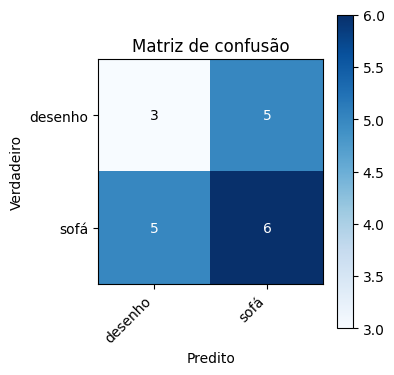

In [17]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import itertools

ds_eval = val_ds           # ou val_ds_pf, se você criou com prefetch

y_true = np.concatenate([y.numpy() for _, y in ds_eval], axis=0).argmax(1)
y_pred = model.predict(ds_eval).argmax(1)

print(classification_report(y_true, y_pred, target_names=DISPLAY_NAMES, digits=3))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(4,4))
plt.imshow(cm, cmap="Blues")
plt.title("Matriz de confusão")
plt.colorbar()
plt.xticks(range(len(DISPLAY_NAMES)), DISPLAY_NAMES, rotation=45, ha="right")
plt.yticks(range(len(DISPLAY_NAMES)), DISPLAY_NAMES)
thresh = cm.max() * 0.6
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], ha="center", va="center",
             color="white" if cm[i, j] > thresh else "black")
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.tight_layout()
plt.show()


In [18]:
import os, pathlib

# DST já está definido no seu notebook:
# DST = "/content/datasets/pbl_fase6_FlaviaBocchino---PedroZani/imagens"

CLASS_NAMES = sorted([p.name for p in pathlib.Path(DST).iterdir() if p.is_dir()])
print("Classes (ordem usada no treino):", CLASS_NAMES)

# (opcional, nomes “bonitos” para o relatório)
DISPLAY_NAMES = ["desenho", "sofá"] if CLASS_NAMES == ["A","B"] else CLASS_NAMES


Classes (ordem usada no treino): []
